In [1]:
# 1. Imports & guaranteed reproducible values
seed_value= 1
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
#import tensorflow as tf
#tf.random.set_seed(seed_value)
# for later versions: 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
# config = tf.ConfigProto(intra_op_parallelism_threads=8,
#                         inter_op_parallelism_threads=2,
#                         allow_soft_placement=True,
#                         device_count = {'CPU' :1, 'GPU' : 1})
config = tf.ConfigProto(allow_soft_placement=True,
                        device_count={'CPU':1, 'GPU':1},
                        inter_op_parallelism_threads=8,
                        intra_op_parallelism_threads=2)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
sess = tf.Session(graph=tf.get_default_graph(), config=config)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from keras_radam.training import RAdamOptimizer # Keras Rectified Adam

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
dataPath = "./m5-forecasting-accuracy"
timesteps = 14 # Use past 14 days sales
startDay = 0 # Used to ignore unwanted days from the beginning

In [3]:
dt = pd.read_csv(dataPath + "/sales_train_validation.csv")
#dt.head(3)

In [4]:
# Downcast integers/floats to reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [5]:
# Reduce memory usage and compare with the previous one to be sure
dt = downcast_dtypes(dt)

* The shape of the data is not exactly what we want.
* We want to have each day as row and 30490 items' sales as columns (features)
* Therefore take the transpose of "dt"

In [6]:
#Take the transpose so that we have one day for each row, and 30490 items' sales as columns
dt = dt.T    
#dt.head(8)

* Remove the first six  colums id, item_id, dept_id, cat_id, store_id, state_id columns, to end up only days as rows

In [7]:
#Remove id, item_id, dept_id, cat_id, store_id, state_id columns
dt = dt[6 + startDay:]
#dt.head(5)

* Here a dataframe is created to store the knowledge if an event exist in the next day
* Firstly, fill with zeros the dataframe
* Now, "1" is assigned the day before an event exist. Other days will remain as "0".

In [8]:
calendar = pd.read_csv(dataPath + "/calendar.csv")
calendar.head(3)

# Create dataframe with zeros for 1969 days in the calendar
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))

# "1" is assigned to the days before the event_name_1. Since "event_name_2" is rare, it was not added.
for x,y in calendar.iterrows():
   if((pd.isnull(calendar["event_name_1"][x])) == False):
           daysBeforeEvent[0][x-1] = 1 # Exception when first day boasts event, because [x-1]
        
#"calendar" won't be used anymore. 
del calendar

* Since, the "daysBeforeEvent" feature is used for predicting after the model trained as input, we seperate the 28 days as "daysBeforeEventTest"
* For training the first 1914 days (if "startDay" is zero otherwise "1913-startDay") will be used.

In [9]:
#"daysBeforeEventTest" will be used as input for predicting (We will forecast the days 1913-1941)
daysBeforeEventTest = daysBeforeEvent[1913:1941]
#"daysBeforeEvent" will be used for training as a feature.
daysBeforeEvent = daysBeforeEvent[startDay:1913]


In [10]:
#Before concatanation with our main data "dt", indexes are made same and column name is changed to "oneDayBeforeEvent"
daysBeforeEvent.columns = ["oneDayBeforeEvent"]
daysBeforeEvent.index = dt.index

* Concatenate "daysBeforeEvent" feature with our main dataframe "dt"

In [11]:
dt = pd.concat([dt, daysBeforeEvent], axis = 1)
#dt.columns

In [12]:
#Feature Scaling
#Scale the features using min-max scaler in range 0-1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dt_scaled = sc.fit_transform(dt)

* Here is the important part. "X_train" and "y_train" data is created. For each X_train item, 14 past days' sales and 14 daysBeforeEvent feature are included. So one element of X_train's shape is (14, 30491). For y_train we are predicting one day sales of 30490 items therefore one element of y_train's shape is (1, 30490)

In [13]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:30490]) 

Creation of X_train and y_train
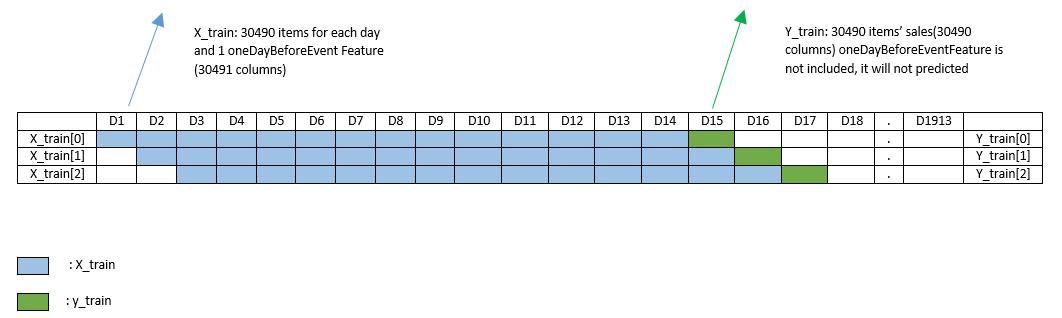

In [14]:
del dt_scaled

In [15]:
#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train)
y_train = np.array(y_train)
#print(X_train.shape)
#print(y_train.shape)

> # Transformer Model with Keras

* Transformer Model obtained from [this](https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/deep-learning/16.attention-is-all-you-need.ipynb).

In [16]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, input_size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50,
                 dropout_rate = 0.8):
        self.X = tf.placeholder(tf.float32, (None, None, input_size))
        self.Y = tf.placeholder(tf.float32, (output_size))
        
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = dropout_rate)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        
#         self.optimizer = RAdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
        self.optimizer = RAdamOptimizer(learning_rate=learning_rate,
                                        total_steps=38400,
                                        warmup_proportion=0.1,
                                        min_lr=1e-6).minimize(self.cost)
#         self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [17]:
def forecast():
    ######################
    # Parameters
    ######################
    num_blocks = 2
    num_heads = 8
    size_layer = 256
    size_embedding = 256
    epoch = 6
    future_day = 1
    learning_rate = 0.03
    tf.reset_default_graph()
    
    modelnn = Attention(size_layer, size_embedding, learning_rate, X_train.shape[2], y_train.shape[1], num_blocks, num_heads)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, X_train.shape[0]):
            batch_x = np.expand_dims(
                X_train[k, :, :], axis = 0
            )
            batch_y = y_train[k, :].T
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:], logits[:]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    # Predict unknown 28 days using last 14 days as a start
    print("Creating predictions")
    inputs= dt[-timesteps:]
    inputs = sc.transform(inputs)
    
    X_test = []
    X_test.append(inputs[0:timesteps])
    X_test = np.array(X_test)
    predictions = []
    for j in range(timesteps,timesteps + 28):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X:X_test[0,j - timesteps:j].reshape(1, timesteps, 30491)
            },
        )
        testInput = np.append(out_logits[-1], daysBeforeEventTest[0][1913 + j - timesteps])
        X_test = np.append(X_test[0], testInput).reshape(1, j+1, 30491)
        
    predictions = sc.inverse_transform(X_test[0])[14:,0:30490]
    print(predictions.shape)
    return predictions

In [18]:
#predictions = []
# for i in range(5):
#     print('simulation %d'%(i + 1))
#     #predictions.append(forecast())
#     predictions = forecast()
    
# predictions = np.mean(predictions)

predictions = forecast()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.


train loop: 100%|████████████████████████████████████████████████| 6/6 [32:20<00:00, 323.43s/it, acc=89.9, cost=0.0151]


Creating predictions
(28, 30490)


* Take last days, 14 for this notebook ("timestep" parameter) in order to predict first unknown day's sales.
* Before using values for prediction, again use min-max transformation

* Here is again an important part. 
* We are using last 14 days in order to predict day 1915 sales.
* In order to predict 1916th day, 13 days from our input data and 1 day from our prediction are used. After that we slide the window one by one.
    * 12 days from input data + 2 days from our prediction to predict 1917th day
    * 11 days from input data + 3 days from our prediction to predict 1918th day
    * .....
    * 14 days our prediction to predict last 1941th day sales.

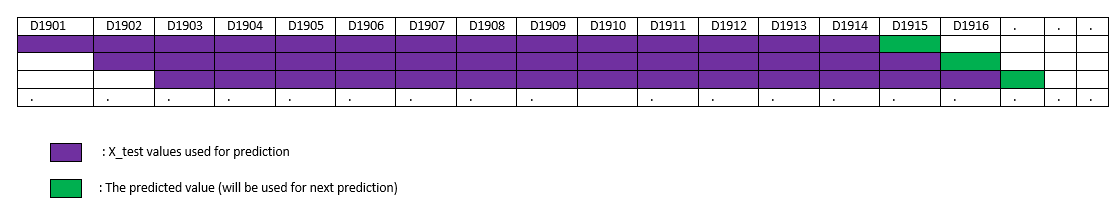

# Submission File Creation
* Here, the submission file creation is done.

In [19]:
import time

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))

submission = submission.T
    
submission = pd.concat((submission, submission), ignore_index=True)

sample_submission = pd.read_csv(dataPath + "/sample_submission.csv")
    
idColumn = sample_submission[["id"]]
    
submission[["id"]] = idColumn  

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

colsdeneme = ["id"] + [f"F{i}" for i in range (1,29)]

submission.columns = colsdeneme

currentDateTime = time.strftime("%d%m%Y_%H%M%S")

submission.to_csv("submission.csv", index=False)

del predictions

In [20]:
from typing import Union

## evaluation metric
## from https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834 and edited to get scores at all levels
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'cat_id',
            'state_id',
            'dept_id',
            'store_id',
            'item_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]):
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())

        return group_ids, all_scores

In [21]:
## reading data
df_train_full = pd.read_csv("./m5-forecasting-accuracy/sales_train_evaluation.csv")
df_calendar = pd.read_csv("./m5-forecasting-accuracy/calendar.csv")
df_prices = pd.read_csv("./m5-forecasting-accuracy/sell_prices.csv")
df_sample_submission = pd.read_csv("./m5-forecasting-accuracy/sample_submission.csv")
df_sample_submission["order"] = range(df_sample_submission.shape[0])

df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]

evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.09s/it]


In [22]:
preds_valid = pd.read_csv("./submission.csv")
preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
preds_valid = preds_valid.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1).reset_index(drop = True)
preds_valid.rename(columns = {
    "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
    "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
    "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
    "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
}, inplace = True)

groups, scores = evaluator.score(preds_valid)

score_public_lb = np.mean(scores)

for i in range(len(groups)):
    print(f"Score for group {groups[i]}: {round(scores[i], 5)}")

print(f"\nPublic LB Score: {round(score_public_lb, 5)}")

Score for group all_id: 1.31291
Score for group cat_id: 1.31308
Score for group state_id: 1.33809
Score for group dept_id: 1.38605
Score for group store_id: 1.32911
Score for group item_id: 1.17685
Score for group ['state_id', 'cat_id']: 1.34404
Score for group ['state_id', 'dept_id']: 1.3968
Score for group ['store_id', 'cat_id']: 1.31503
Score for group ['store_id', 'dept_id']: 1.3841
Score for group ['item_id', 'state_id']: 1.11246
Score for group ['item_id', 'store_id']: 1.0568

Public LB Score: 1.28878
